#EECS 442/504 PS8: Panoramic Stitching

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Bernardo Bianco Prado, beprado

__Important__: after you download the .ipynb file, please name it as __"PS\<this_ps_number\>_\<your_uniqname\>.ipynb"__ before you submit it to canvas. Example: PS8_adam.ipynb.


# Brief Overview

In this problem set, you will implement panoramic stitching. Given two input images, we will "stitch" them together to create a simple panorama. To construct the image panorama, we will use concepts learned in class such as keypoint detection, local invariant descriptors, RANSAC, and perspective warping. 

The panoramic stitching algorithm consists of four main steps which we ask you to implement in individual functions:

1. Detect keypoints and extract local invariant descriptors (we will be using ORB) from two input images. 

2. Match the descriptors between the two images.

3. Apply RANSAC to estimate a homography matrix between the extracted features.

4. Apply a perspective transformation using the homography matrix to merge image into a panorama.

Functions to implement (refer to function comments for more detail):

1. `get_orb_features` (2 points)

2. `match_keypoints` (2 points)

3. `find_homography` (2 points)

4. `transform_ransac` (2 points)

5. `panoramic_stitching` (2 points)

# Getting started

Run the following code to import the modules you'll need.

In [ ]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

# Visualize Input Images

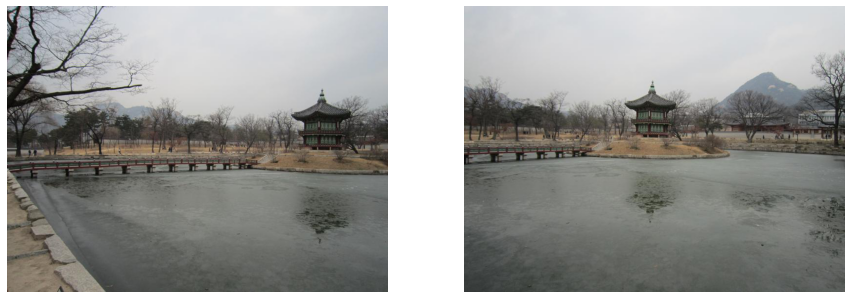

In [ ]:
img1 = plt.imread('img1.jpg')
img2 = plt.imread('img2.jpg')

def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(img1)
  ax[1].imshow(img2)

plot_imgs(img1, img2)

# (a) Feature Extraction

## (i) Compute ORB Features

In [ ]:
def get_orb_features(img):
  '''
    Compute ORB features using cv2 library functions. 
    Use default parameters when computing the keypoints.
    Hint: you will need cv2.ORB_create() and some related functions
    Input: 
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of ORB descriptors
  '''
  #############################################################################
  #                                   TODO                                    #
  #############################################################################

  orb = cv2.ORB_create()
  keypoints, descriptors = orb.detectAndCompute(img, None)

  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
  
  return keypoints, descriptors

## (ii) Match Keypoints

In [ ]:
def match_keypoints(desc_1, desc_2, ratio=0.75):
  '''
    Compute matches between feature descriptors of two images using 
    Lowe's ratio test. You may use cv2 library functions.
    Hint: you may need to use cv2.DescriptorMatcher_create or cv2.BFMatcher 
    and some related functions
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
  '''
  #############################################################################
  #                                   TODO                                    #
  #############################################################################
  
  matcher =  cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.knnMatch(desc_1, desc_2, k=2)
  # use ratio test to keep the best matches
  keep = []
  for m1, m2 in matches:
    if m1.distance < ratio * m2.distance:
      keep.append(m1)
  matches = keep
  
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return matches

keypoints for img1 and img2


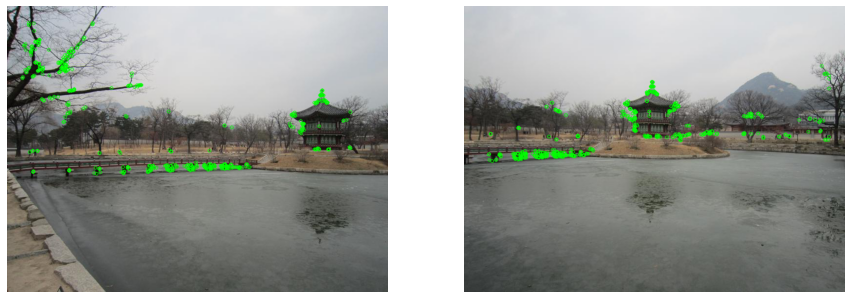

In [ ]:
kp_1, desc_1 = get_orb_features(img1)
kp_2, desc_2 = get_orb_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

print('keypoints for img1 and img2')
plot_imgs(kp_img1, kp_img2)

orb feature matches


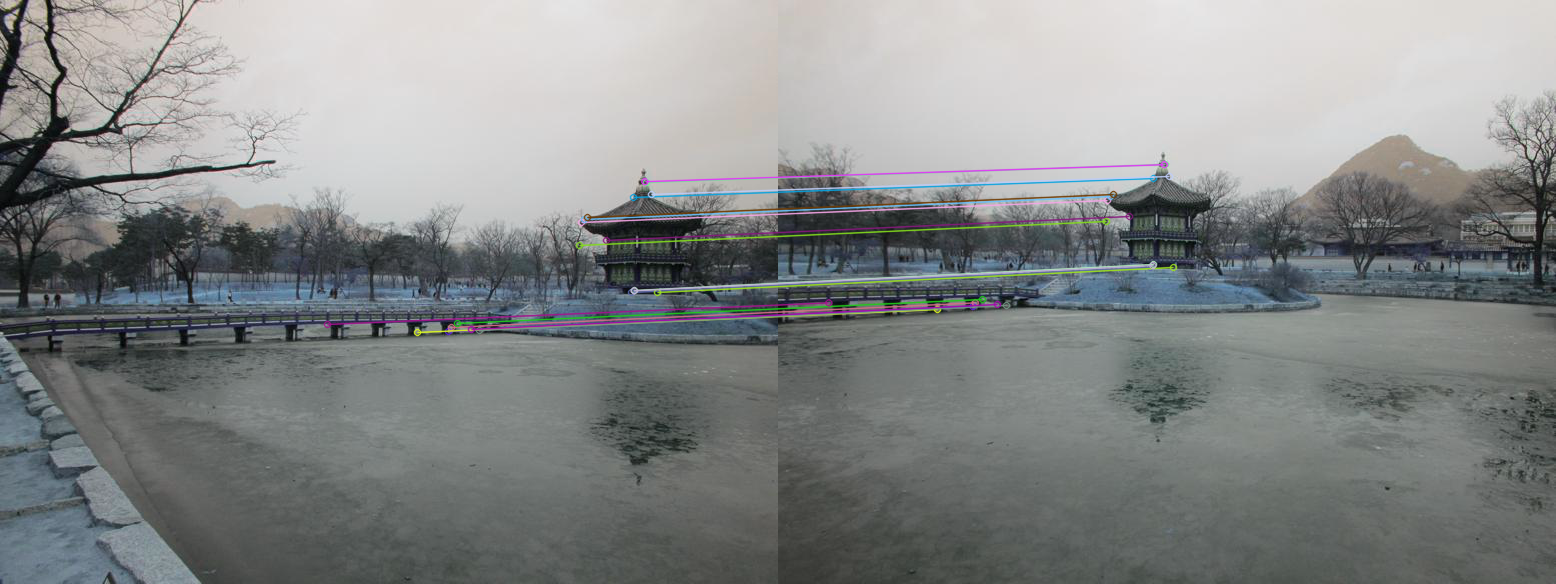

In [ ]:
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:20], None, flags=2)
print("orb feature matches")
cv2_imshow(match_plot)

# (b) Find Homography Matrix

In [ ]:
from scipy.optimize import least_squares

##### HELPER FUNCTIONS THAT ARE USED LATER ##################################
homogeneous = lambda x : np.concatenate((x, np.ones([x.shape[0],1])), axis=1)
cart = lambda x : x[:,0:2] / x[:,2:]
#############################################################################

def find_homography(pts_1, pts_2):
  '''
    Use either nonlinear least squares or direct linear transform 
    to find a homography that estimates the transformation mapping from pts_1 
    to pts_2.
    e.g. If x is in pts_1 and y is in pts_2, then y = H * x

    Hint if using nonlinear least square: 
      The objective function to optimize here is: 
      ||pts_1 - cart(H*homog(pts_2))||^2 where homog(x) converts x into 
      homogeneous coordinates and cart(x) converts x to cartesian coordinates.
      You can use scipy.optimize.least_squares for this.

    Hint if using direct linear transform: 
      The solution is given by the right-singular vector with the smallest singular value in the singular vector decomposition. 
      You can use np.linalg.svd for this. 

    Input:
      pts_1, pts_2: (N, 2) matrix 
    Return:
      H: the resultant homography matrix (3 x 3)
  '''
  #############################################################################
  #                                   TODO                                    #
  #############################################################################
  # create matrix to take the svd of
  pts_1_hom = homogeneous(pts_1)
  matrix_1 = np.concatenate((-pts_1_hom, np.zeros(pts_1_hom.shape), pts_2[:,0:1] * pts_1_hom), axis=1)
  matrix_2 = np.concatenate((np.zeros(pts_1_hom.shape), -pts_1_hom, pts_2[:,1:2] * pts_1_hom), axis=1)
  full_matrix = np.concatenate((matrix_1, matrix_2), axis=0)
  # take the svd of the matrix and define the homography
  u, s, vh = np.linalg.svd(full_matrix, full_matrices=False)
  H = vh[-1].reshape([3,3])
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
  
  return H

# (c) Implement RANSAC

In [ ]:
def transform_ransac(pts_1, pts_2, verbose=False):
  '''
    Implements RANSAC to estimate homography matrix. 
    Hint: Follow the RANSAC steps outlined in the lecture slides. 
    Hint: Try num iterations = 1000 (not mandatory)
    Hint: Threshold ε =2 (ε here refers to the L2 distance between two points)
    Input:
      pts_1, pts_2: (N, 2) matrices
    Return:
      best_model: homography matrix with most inliers
  '''
  #############################################################################
  #                                   TODO                                    #
  #############################################################################
  
  eps = 2 # threshold
  num_rand_pts = 10
  iterations = 20000
  best_model = np.zeros([3,3])
  best_model_score = 0
  indices = np.arange(pts_1.shape[0])

  for i in range(iterations):
    rand_pts_indices = np.random.choice(indices, 4, replace = False)
    rand_pts_1 = pts_1[rand_pts_indices]
    rand_pts_2 = pts_2[rand_pts_indices]
    homog = find_homography(rand_pts_1, rand_pts_2)
    difference = np.linalg.norm(pts_2 - cart(homogeneous(pts_1)@homog.T), axis=1)
    score = np.sum(difference < eps)
    if score > best_model_score:
      best_model = homog
      best_model_score = score

  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
  
  return best_model

# (d) Panoramic Stitching

In [ ]:
def panoramic_stitching(img1, img2):
  '''
    Given a pair of overlapping images, generate a panoramic image. 
    Hint: use the functions that you've written in the previous parts.
    Input: 
      img1, img2: cv2 images
    Return:
      final_img: cv2 image of panorama
  '''
  #############################################################################
  #                                   TODO                                    #
  # 1. detect keypoints and extract orb feature descriptors                   #
  # 2. match features between two images                                      #
  # 3. compute homography matrix H transforming points from pts_2 to pts_1.   #
  # Note the order here (not pts_1 to pts_2)!                                 #
  #############################################################################
  kp_1, desc_1 = get_orb_features(img1)
  kp_2, desc_2 = get_orb_features(img2)
  matches =  match_keypoints(desc_1,desc_2)

  pts_1 = np.zeros([len(matches), 2])
  pts_2 = np.zeros([len(matches), 2])

  for i, match in enumerate(matches):
    pts_1[i,:] = kp_1[match.queryIdx].pt
    pts_2[i,:] = kp_2[match.trainIdx].pt

  H = transform_ransac(pts_2, pts_1)
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
  
  # apply perspective wrap to stitch images together
  final_img = cv2.warpPerspective(img2, H, (img2.shape[1] + img1.shape[1], img2.shape[0] * 2))
  final_img[0:img1.shape[0], 0:img1.shape[1]] = img1

  return final_img

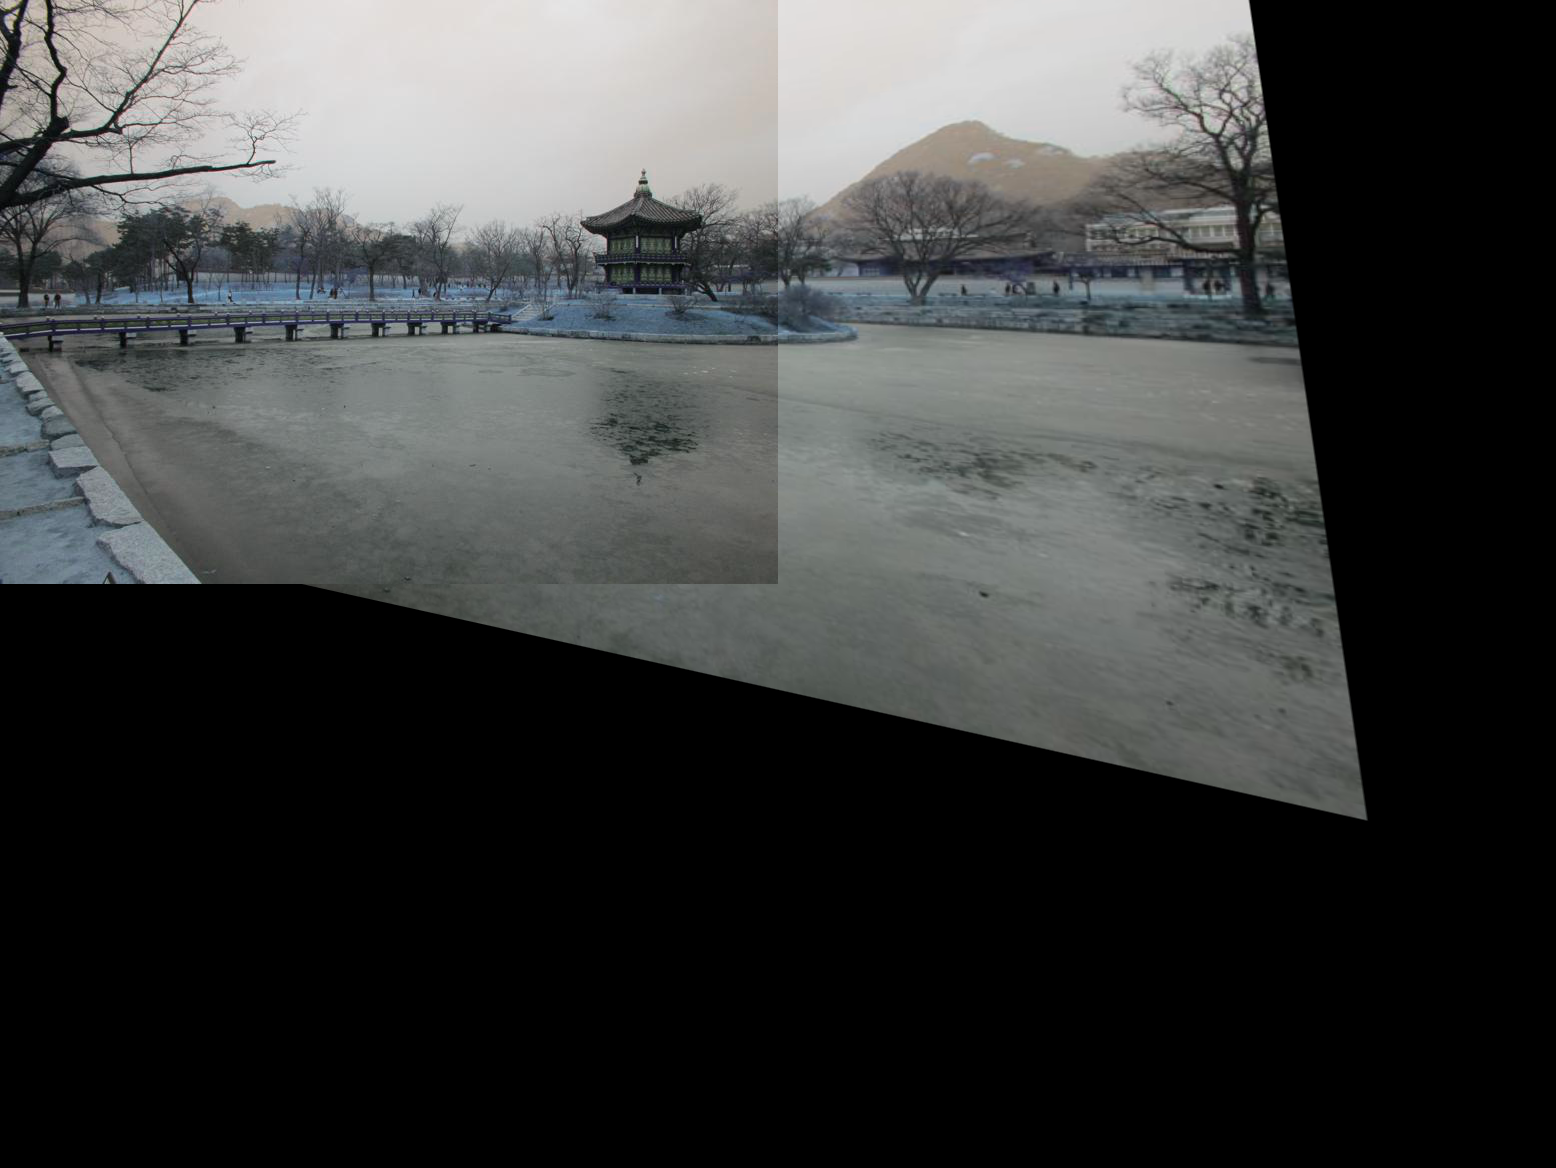

In [ ]:
result = panoramic_stitching(img1, img2)
cv2_imshow(result)

# Convert to PDF

[Alternative if the cell below doesn't work.](https://docs.google.com/document/d/1QTutnoApRow8cOxNrKK6ISEkA72QGfwLFXbIcpvarAI/edit?usp=sharing)

In [1]:
import os
from google.colab import drive
from google.colab import files

drive_mount_point = '/content/drive/'
drive.mount(drive_mount_point)

Mounted at /content/drive/


In [3]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!

# Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/ps8_panoramic_stitching_starter.ipynb'
notebookpath = "/content/drive/My Drive/Colab Notebooks/PS8_beprado.ipynb"

file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
files.download(notebookpath.split('.')[0]+'.pdf')

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [22.8 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,559 kB]
Get:15 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [3,065 k

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>